# SHAP Explanations Template for Machine Learning Models

This notebook provides a reusable framework for generating **SHAP (SHapley Additive exPlanations)** explanations for any classification or regression model.

## Features
- Support for both classification and regression tasks
- Multiple model types (tree-based, linear, neural networks)
- Configurable output directory and file naming
- Interactive and static visualizations
- Export capabilities for reports and dashboards

## Usage
1. Modify the **CONFIG** dictionary to customize settings for your use case
2. Run the cells sequentially to generate SHAP explanations
3. Visualizations will be saved to the specified output directory

---

## 1. Import Required Libraries

Import necessary libraries including shap, numpy, pandas, scikit-learn, and visualization tools.

In [1]:
import os
import sys
import json
import logging
from pathlib import Path
from datetime import datetime
from typing import Optional, Union, List, Dict, Any, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.datasets import make_classification, make_regression

# Enable SHAP plots in notebook
shap.initjs()

print("All libraries imported successfully!")

c:\Users\christava\Documents\src\github.com\ctava-msft\customers-top\upmc-top\upmc-mlstudio-automl-jobs\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All libraries imported successfully!


## 2. Configuration

Modify these settings to customize the behavior for your use case.

In [2]:
# =============================================================================
# CONFIGURATION - Modify these settings for your use case
# =============================================================================

CONFIG = {
    # Data settings
    "target_column": "target",          # Name of your target column
    "sample_size": 100,                  # Number of samples for SHAP analysis
    "test_size": 0.2,                    # Train/test split ratio
    "random_state": 42,                  # Random seed for reproducibility
    
    # Model settings
    "task_type": "classification",       # "classification" or "regression"
    "model_type": "tree",                # "tree", "linear", "kernel", or "deep"
    
    # Output settings
    "output_dir": "./explanations",      # Directory for saving outputs
    "save_format": "png",                # Image format: "png", "pdf", "svg"
    "dpi": 300,                          # Image resolution
    "create_html": True,                 # Generate interactive HTML plots
    
    # Visualization settings
    "max_features_display": 20,          # Max features to show in plots
    "color_positive": "#ff0051",         # Color for positive SHAP values
    "color_negative": "#008bfb",         # Color for negative SHAP values
}

# Create output directory
Path(CONFIG["output_dir"]).mkdir(parents=True, exist_ok=True)

print("Configuration loaded:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration loaded:
  target_column: target
  sample_size: 100
  test_size: 0.2
  random_state: 42
  task_type: classification
  model_type: tree
  output_dir: ./explanations
  save_format: png
  dpi: 300
  create_html: True
  max_features_display: 20
  color_positive: #ff0051
  color_negative: #008bfb


## 3. Load or Prepare Dataset

Load a dataset for demonstration purposes. You can replace this with your own data loading logic.

In [3]:
def create_demo_data(
    n_samples: int = 1000,
    n_features: int = 10,
    task_type: str = "classification",
    feature_names: Optional[List[str]] = None
) -> Tuple[pd.DataFrame, np.ndarray, List[str]]:
    """
    Create synthetic demo data for testing.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    n_features : int
        Number of features
    task_type : str
        "classification" or "regression"
    feature_names : List[str], optional
        Custom feature names
    
    Returns:
    --------
    Tuple[pd.DataFrame, np.ndarray, List[str]]
        Features, target, and feature names
    """
    if feature_names is None:
        # Create meaningful feature names for healthcare context
        default_names = [
            'age', 'bmi', 'blood_pressure', 'cholesterol', 'glucose',
            'heart_rate', 'smoking_status', 'exercise_freq', 'family_history',
            'medication_count', 'sleep_hours', 'stress_level', 'diet_score',
            'alcohol_consumption', 'previous_conditions'
        ]
        feature_names = default_names[:n_features] if n_features <= len(default_names) else \
                        default_names + [f"feature_{i}" for i in range(len(default_names), n_features)]
    
    if task_type == "classification":
        X, y = make_classification(
            n_samples=n_samples,
            n_features=n_features,
            n_informative=min(8, n_features),
            n_redundant=min(2, n_features - 8) if n_features > 8 else 0,
            n_classes=2,
            random_state=CONFIG["random_state"]
        )
    else:
        X, y = make_regression(
            n_samples=n_samples,
            n_features=n_features,
            n_informative=min(8, n_features),
            noise=10,
            random_state=CONFIG["random_state"]
        )
    
    df = pd.DataFrame(X, columns=feature_names)
    
    return df, y, feature_names


# Create demo dataset
print("Creating demo dataset...")
X, y, feature_names = create_demo_data(
    n_samples=1000,
    n_features=10,
    task_type=CONFIG["task_type"]
)

print(f"Dataset shape: {X.shape}")
print(f"Features: {feature_names}")
print(f"Target distribution: {pd.Series(y).value_counts().to_dict()}")

# Display first few rows
X.head()

Creating demo dataset...
Dataset shape: (1000, 10)
Features: ['age', 'bmi', 'blood_pressure', 'cholesterol', 'glucose', 'heart_rate', 'smoking_status', 'exercise_freq', 'family_history', 'medication_count']
Target distribution: {1: 500, 0: 500}


,age,bmi,blood_pressure,cholesterol,glucose,heart_rate,smoking_status,exercise_freq,family_history,medication_count
0,-0.224515,-0.648598,2.805591,0.569525,2.676771,0.685312,0.306675,1.147291,-2.145905,2.477879
1,1.038548,-1.316803,2.303387,1.233593,4.972675,1.086905,-3.548788,0.342810,-0.469005,2.787109
2,1.148988,1.794382,2.835693,-1.114858,-1.247120,-1.899268,-0.381470,0.837209,0.163223,-0.997959
3,-1.177318,2.420294,-0.363514,-1.086646,-2.824750,-2.722123,-0.225266,0.515079,-3.317272,-2.801517
4,1.346717,0.089373,2.056613,-0.428365,0.285387,1.140716,0.721945,1.110152,2.426608,0.880496


### Alternative: Load Your Own Data

Uncomment and modify the cell below to load your own data instead of using demo data.

In [4]:
# =============================================================================
# ALTERNATIVE: Load your own data
# =============================================================================

# # Load from CSV
# data_path = "your_data.csv"
# target_column = "your_target_column"
# 
# df = pd.read_csv(data_path)
# X = df.drop(columns=[target_column])
# y = df[target_column].values
# feature_names = list(X.columns)
# 
# print(f"Loaded {len(df)} rows with {len(feature_names)} features")
# print(f"Features: {feature_names}")

## 4. Train Machine Learning Model

Train a model on the training data. The model type is determined by the CONFIG settings.

In [5]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=CONFIG["test_size"], 
    random_state=CONFIG["random_state"]
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 800 samples
Test set: 200 samples


In [6]:
def train_model(
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    X_test: pd.DataFrame,
    y_test: np.ndarray,
    task_type: str = "classification",
    model_type: str = "tree"
) -> Any:
    """
    Train a model based on the specified type.
    
    Parameters:
    -----------
    X_train, y_train : Training data
    X_test, y_test : Test data for evaluation
    task_type : "classification" or "regression"
    model_type : "tree", "linear", or "gradient_boosting"
    
    Returns:
    --------
    Trained model
    """
    if task_type == "classification":
        if model_type == "tree":
            model = RandomForestClassifier(n_estimators=100, random_state=CONFIG["random_state"])
        elif model_type == "gradient_boosting":
            model = GradientBoostingClassifier(n_estimators=100, random_state=CONFIG["random_state"])
        else:
            model = LogisticRegression(max_iter=1000, random_state=CONFIG["random_state"])
    else:
        if model_type == "tree":
            model = RandomForestRegressor(n_estimators=100, random_state=CONFIG["random_state"])
        elif model_type == "gradient_boosting":
            model = GradientBoostingRegressor(n_estimators=100, random_state=CONFIG["random_state"])
        else:
            model = LinearRegression()
    
    # Train the model
    print(f"Training {model.__class__.__name__}...")
    model.fit(X_train, y_train)
    
    # Evaluate
    if task_type == "classification":
        accuracy = model.score(X_test, y_test)
        print(f"Model accuracy: {accuracy:.3f}")
    else:
        r2 = model.score(X_test, y_test)
        print(f"Model R² score: {r2:.3f}")
    
    return model


# Train the model
model = train_model(
    X_train, y_train, X_test, y_test,
    task_type=CONFIG["task_type"],
    model_type=CONFIG["model_type"]
)

Training RandomForestClassifier...
Model accuracy: 0.870
Model accuracy: 0.870


## 5. Initialize SHAP Explainer

Create a SHAP explainer object appropriate for the model type.

In [7]:
def create_shap_explainer(model, background_data: pd.DataFrame, model_type: str = "tree"):
    """
    Create the appropriate SHAP explainer based on model type.
    
    Parameters:
    -----------
    model : Trained model
    background_data : Training data used as background for SHAP
    model_type : "tree", "linear", "kernel", or "deep"
    
    Returns:
    --------
    SHAP explainer object
    """
    if model_type == "tree":
        print("Using TreeExplainer (optimized for tree-based models)")
        return shap.TreeExplainer(model)
    
    elif model_type == "linear":
        print("Using LinearExplainer (optimized for linear models)")
        return shap.LinearExplainer(model, background_data)
    
    elif model_type == "deep":
        print("Using DeepExplainer (for neural networks)")
        return shap.DeepExplainer(model, background_data.values)
    
    else:  # kernel or unknown
        print("Using KernelExplainer (model-agnostic, slower)")
        background_sample = shap.sample(background_data, min(100, len(background_data)))
        return shap.KernelExplainer(model.predict_proba, background_sample)


# Create SHAP explainer
explainer = create_shap_explainer(model, X_train, CONFIG["model_type"])
print(f"Explainer created: {type(explainer).__name__}")

Using TreeExplainer (optimized for tree-based models)
Explainer created: TreeExplainer


## 6. Calculate SHAP Values

Compute SHAP values for the test set to explain model predictions.

In [8]:
# Sample test data if needed (for efficiency)
sample_size = CONFIG["sample_size"]
if len(X_test) > sample_size:
    print(f"Sampling {sample_size} from {len(X_test)} test instances")
    X_explain = X_test.sample(n=sample_size, random_state=CONFIG["random_state"])
else:
    X_explain = X_test

# Calculate SHAP values using the new API (returns Explanation object)
print(f"Calculating SHAP values for {len(X_explain)} samples...")
shap_values = explainer(X_explain)

# For binary classification, extract positive class SHAP values
if CONFIG["task_type"] == "classification" and len(shap_values.values.shape) == 3:
    print("Using positive class SHAP values for binary classification")
    shap_values_display = shap_values[:, :, 1]  # Positive class
else:
    shap_values_display = shap_values

print(f"SHAP values shape: {shap_values_display.values.shape}")
print("SHAP values calculated successfully!")

Sampling 100 from 200 test instances
Calculating SHAP values for 100 samples...
Using positive class SHAP values for binary classification
SHAP values shape: (100, 10)
SHAP values calculated successfully!
Using positive class SHAP values for binary classification
SHAP values shape: (100, 10)
SHAP values calculated successfully!


### Get Top Features by SHAP Importance

Identify the most important features based on mean absolute SHAP values.

In [9]:
# Calculate mean absolute SHAP values per feature
mean_abs_shap = np.abs(shap_values_display.values).mean(axis=0)

# Create a ranked DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False)

importance_df['rank'] = range(1, len(importance_df) + 1)
importance_df = importance_df[['rank', 'feature', 'mean_abs_shap']]

print("Top 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))

# Save to CSV
csv_path = Path(CONFIG["output_dir"]) / "top_features.csv"
importance_df.to_csv(csv_path, index=False)
print(f"\nFeature importance saved to: {csv_path}")

Top 10 Most Important Features:
 rank          feature  mean_abs_shap
    1   family_history       0.092195
    2      cholesterol       0.073653
    3    exercise_freq       0.069174
    4              age       0.057940
    5   smoking_status       0.053972
    6       heart_rate       0.034615
    7          glucose       0.024342
    8   blood_pressure       0.023869
    9 medication_count       0.019139
   10              bmi       0.013309

Feature importance saved to: explanations\top_features.csv


## 7. Visualize SHAP Summary Plot (Feature Importance)

Create a bar plot showing mean absolute SHAP values per feature.

Feature importance plot saved to: explanations\feature_importance.png


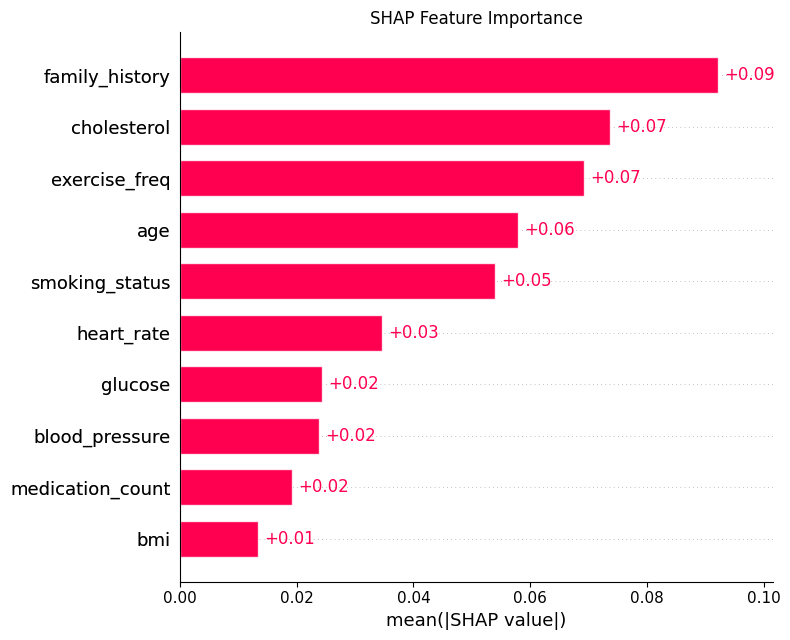

In [10]:
# Feature Importance Bar Plot
plt.figure(figsize=(10, 6))
shap.plots.bar(shap_values_display, max_display=CONFIG["max_features_display"], show=False)
plt.title('SHAP Feature Importance')
plt.tight_layout()

# Save the plot
output_path = Path(CONFIG["output_dir"]) / f"feature_importance.{CONFIG['save_format']}"
plt.savefig(output_path, dpi=CONFIG["dpi"], bbox_inches='tight')
print(f"Feature importance plot saved to: {output_path}")

plt.show()

### Beeswarm Summary Plot

Create a beeswarm plot showing the distribution of SHAP values for each feature.

Summary plot saved to: explanations\summary_beeswarm.png


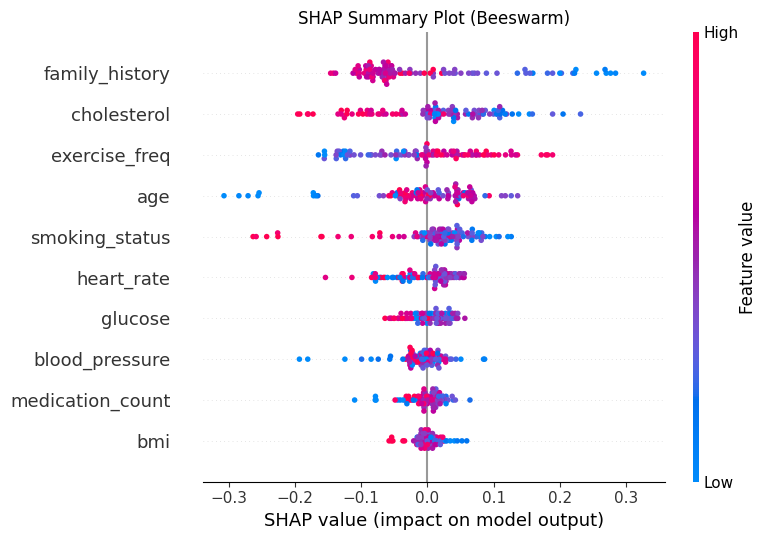

In [11]:
# Beeswarm Summary Plot
plt.figure(figsize=(10, 8))
shap.plots.beeswarm(shap_values_display, max_display=CONFIG["max_features_display"], show=False)
plt.title('SHAP Summary Plot (Beeswarm)')
plt.tight_layout()

# Save the plot
output_path = Path(CONFIG["output_dir"]) / f"summary_beeswarm.{CONFIG['save_format']}"
plt.savefig(output_path, dpi=CONFIG["dpi"], bbox_inches='tight')
print(f"Summary plot saved to: {output_path}")

plt.show()

## 8. Visualize SHAP Waterfall Plot

Create a waterfall plot for individual predictions, showing how each feature contributes.

Waterfall plot saved to: explanations\waterfall_sample_0.png


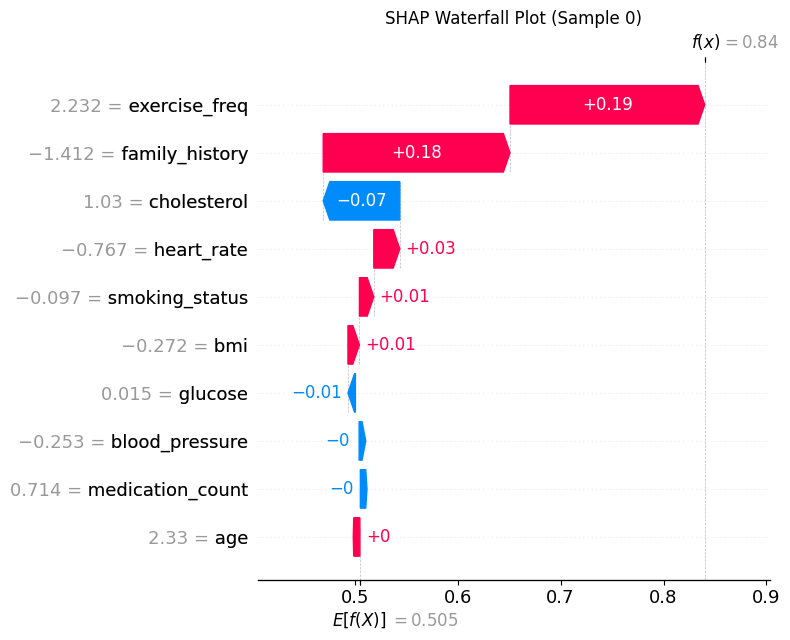

In [12]:
# Waterfall Plot for first sample
sample_index = 0

plt.figure(figsize=(10, 8))
shap.plots.waterfall(shap_values_display[sample_index], max_display=CONFIG["max_features_display"], show=False)
plt.title(f'SHAP Waterfall Plot (Sample {sample_index})')
plt.tight_layout()

# Save the plot
output_path = Path(CONFIG["output_dir"]) / f"waterfall_sample_{sample_index}.{CONFIG['save_format']}"
plt.savefig(output_path, dpi=CONFIG["dpi"], bbox_inches='tight')
print(f"Waterfall plot saved to: {output_path}")

plt.show()

## 9. Visualize SHAP Force Plot

Generate interactive force plots to explain individual predictions.

In [13]:
# Force Plot for a single prediction
sample_index = 0
sample_shap = shap_values_display[sample_index]

# Create force plot
force_plot = shap.force_plot(
    sample_shap.base_values,
    sample_shap.values,
    sample_shap.data,
    feature_names=feature_names
)

# Display in notebook
display(force_plot)

# Save as HTML
if CONFIG["create_html"]:
    html_path = Path(CONFIG["output_dir"]) / "force_plot.html"
    shap.save_html(str(html_path), force_plot)
    print(f"Force plot HTML saved to: {html_path}")

Force plot HTML saved to: explanations\force_plot.html


## 10. Visualize SHAP Dependence Plot

Create dependence plots to show the relationship between a feature's value and its SHAP value.

Creating dependence plot for most important feature: family_history
Dependence plot saved to: explanations\dependence_family_history.png
Dependence plot saved to: explanations\dependence_family_history.png


<Figure size 1000x600 with 0 Axes>

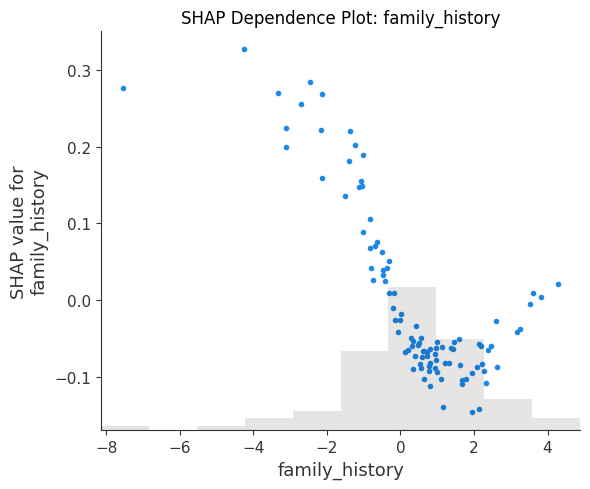

In [14]:
# Find the most important feature for dependence plot
top_feature = importance_df.iloc[0]['feature']
top_feature_idx = feature_names.index(top_feature)

print(f"Creating dependence plot for most important feature: {top_feature}")

plt.figure(figsize=(10, 6))
shap.plots.scatter(shap_values_display[:, top_feature_idx], show=False)
plt.title(f'SHAP Dependence Plot: {top_feature}')
plt.tight_layout()

# Save the plot
output_path = Path(CONFIG["output_dir"]) / f"dependence_{top_feature}.{CONFIG['save_format']}"
plt.savefig(output_path, dpi=CONFIG["dpi"], bbox_inches='tight')
print(f"Dependence plot saved to: {output_path}")

plt.show()

### Dependence Plots for Top 3 Features

Visualize how the top 3 most important features affect model predictions.

Top 3 dependence plots saved to: explanations\dependence_top3.png


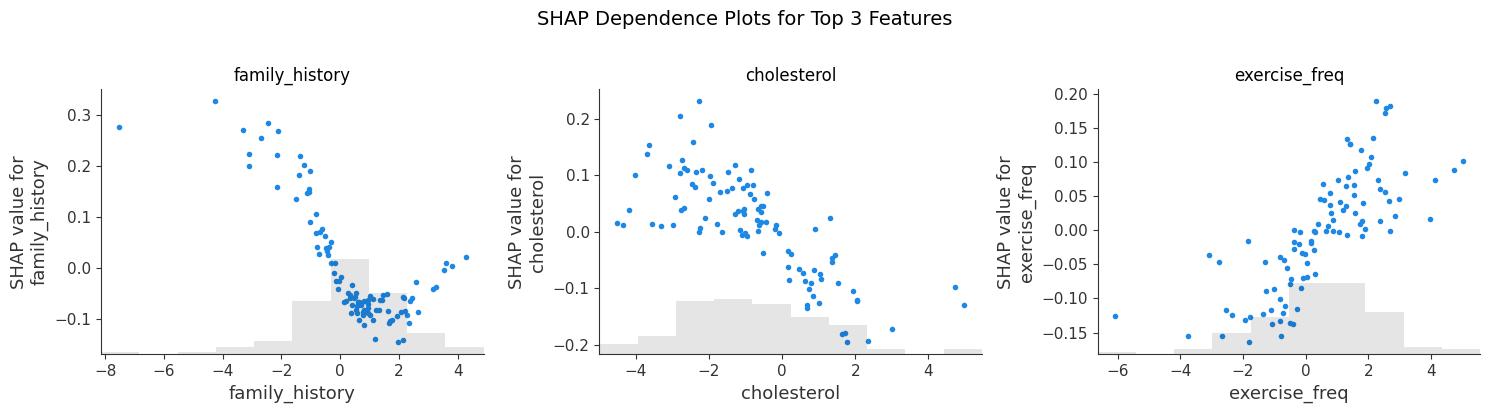

In [15]:
# Create dependence plots for top 3 features
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

top_3_features = importance_df.head(3)['feature'].tolist()

for idx, feature in enumerate(top_3_features):
    feature_idx = feature_names.index(feature)
    plt.sca(axes[idx])
    shap.plots.scatter(shap_values_display[:, feature_idx], show=False, ax=axes[idx])
    axes[idx].set_title(f'{feature}')

plt.suptitle('SHAP Dependence Plots for Top 3 Features', fontsize=14, y=1.02)
plt.tight_layout()

# Save the plot
output_path = Path(CONFIG["output_dir"]) / f"dependence_top3.{CONFIG['save_format']}"
plt.savefig(output_path, dpi=CONFIG["dpi"], bbox_inches='tight')
print(f"Top 3 dependence plots saved to: {output_path}")

plt.show()

## 11. Summary

Print a summary of all generated outputs.

In [16]:
# List all generated files
output_dir = Path(CONFIG["output_dir"])
generated_files = list(output_dir.glob("*"))

print("=" * 70)
print("SHAP Explanations Generated Successfully!")
print("=" * 70)
print(f"\nOutput directory: {output_dir.absolute()}")
print(f"\nGenerated files ({len(generated_files)} total):")
for f in sorted(generated_files):
    print(f"  - {f.name}")

print("\nTop 5 Most Important Features:")
for _, row in importance_df.head(5).iterrows():
    print(f"  {int(row['rank'])}. {row['feature']}: {row['mean_abs_shap']:.4f}")

print("=" * 70)

SHAP Explanations Generated Successfully!

Output directory: c:\Users\christava\Documents\src\github.com\ctava-msft\customers-top\upmc-top\upmc-mlstudio-automl-jobs\explanations

Generated files (13 total):
  - demo_dependence.png
  - demo_feature_importance.png
  - demo_force_plot.html
  - demo_summary.png
  - demo_top_features.csv
  - demo_waterfall.png
  - dependence_family_history.png
  - dependence_top3.png
  - feature_importance.png
  - force_plot.html
  - summary_beeswarm.png
  - top_features.csv
  - waterfall_sample_0.png

Top 5 Most Important Features:
  1. family_history: 0.0922
  2. cholesterol: 0.0737
  3. exercise_freq: 0.0692
  4. age: 0.0579
  5. smoking_status: 0.0540


---

## Appendix: Azure ML Integration Example

Use this code template to generate SHAP explanations for models registered in Azure ML.

In [17]:
# =============================================================================
# AZURE ML INTEGRATION EXAMPLE
# =============================================================================
# Uncomment and modify this code to use with Azure ML registered models

# import mlflow
# from azure.ai.ml import MLClient
# from azure.identity import DefaultAzureCredential

# # 1. Connect to Azure ML Workspace
# ml_client = MLClient(
#     credential=DefaultAzureCredential(),
#     subscription_id="YOUR_SUBSCRIPTION_ID",
#     resource_group_name="YOUR_RESOURCE_GROUP",
#     workspace_name="YOUR_WORKSPACE_NAME"
# )

# # 2. Download and Load Your Model
# model_name = "your-model-name"
# model_version = "1"

# model_download_path = ml_client.models.download(
#     name=model_name,
#     version=model_version,
#     download_path="./downloaded_model"
# )

# # Load the model using MLflow
# model = mlflow.sklearn.load_model(model_download_path)

# # 3. Load Your Data
# data = pd.read_csv("your_data.csv")
# target_column = "your_target_column"
# X = data.drop(columns=[target_column])
# y = data[target_column]

# # 4. Generate SHAP Explanations (follow the cells above)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# explainer = shap.TreeExplainer(model)  # or appropriate explainer
# shap_values = explainer(X_test.sample(100))

# # 5. Optional: Upload Explanations to Azure ML as Data Asset
# from azure.ai.ml.entities import Data
# from azure.ai.ml.constants import AssetTypes
# 
# explanation_data = Data(
#     name="model-explanations",
#     path=CONFIG["output_dir"],
#     type=AssetTypes.URI_FOLDER,
#     description="SHAP explanations for model"
# )
# ml_client.data.create_or_update(explanation_data)

print("Azure ML integration example (uncomment to use)")

Azure ML integration example (uncomment to use)
